In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cookies1/cookies.txt
/kaggle/input/yelp-dataset/Dataset_User_Agreement.pdf
/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json


In [2]:
pip install ijson
pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 266.1 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Imports

import numpy as np
import pandas as pd
from wordcloud import WordCloud
from nltk.corpus import stopwords
import string
import re
from wordcloud import WordCloud, STOPWORDS
import ijson
from pandas.io.json import json_normalize
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print(__version__) # requires version >= 1.9.0
import cufflinks as cf
# For offline use
cf.go_offline()
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import numpy as np
import pandas as pd
from pprint import pprint


In [4]:
import json

def init_ds(json):
    ds= {}
    keys = json.keys()
    for k in keys:
        ds[k]= []
    return ds, keys

def read_json(file):
    dataset = {}
    keys = []
    with open(file) as file_lines:
        for count, line in enumerate(file_lines):
            data = json.loads(line.strip())
            if count ==0:
                dataset, keys = init_ds(data)
            for k in keys:
                dataset[k].append(data[k])
                
        return pd.DataFrame(dataset)

In [5]:
%%time

yelp_review= read_json('/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json')

CPU times: user 1min 25s, sys: 13.4 s, total: 1min 39s
Wall time: 2min 10s


In [6]:
yelp_business= read_json('/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json')

In [7]:
#merge both the datasets
yelp = pd.merge(yelp_review, yelp_business, how='inner')

In [8]:
# look at the null values in yelp categories
pd.set_option("display.max_rows", None)
yelp[yelp['categories'].isnull()].head(10)

review_id                 user_id             business_id  \
77330  Ip7rDFZXZHmVGjtk1Sg8JA  l1TVWV45iN6QVzw--oW8qA  9QoKKDZB_YuDeS5TxRW8bg   
77331  Li-TkZ6hAGpiFS2IjzBNVw  P4xaN82k39NPSC8Qxh40mg  9QoKKDZB_YuDeS5TxRW8bg   
77332  bLKuvjTUv18b3ZnZBQTpkg  FGgnfpTySh4OKrKvhEWcYg  9QoKKDZB_YuDeS5TxRW8bg   
77333  A6dSeSsPkjyLVK2nVxjkVw  DDQBgBcRBHy49TEgx_eAiQ  9QoKKDZB_YuDeS5TxRW8bg   
77334  pxQqSoG-Afpv1aDcCROtQg  6TmlTliditsOe4-xBzPcpQ  9QoKKDZB_YuDeS5TxRW8bg   
77335  jEPnUygxahaQnYyf1k3RGQ  zQcrBI9x10qttUa7UOQdQA  9QoKKDZB_YuDeS5TxRW8bg   
77336  ffaecUWQLh4MZu0Xb8kJQQ  FvxKFy6N9_N-0E70oIjNhQ  9QoKKDZB_YuDeS5TxRW8bg   
77337  AR57j2wMTr_AzaMZrAjVDA  AaHgQ1oRuL5WJJu-OZN_sQ  9QoKKDZB_YuDeS5TxRW8bg   
77338  bVazE0iFmlCajEH5BdSANw  gRthF2DnTCbcp2_DcP6bwg  9QoKKDZB_YuDeS5TxRW8bg   
77339  husmRCacdRAtIduun5BlbA  kB3PYu6sN2jDk43grSC6rg  9QoKKDZB_YuDeS5TxRW8bg   

       stars  useful  funny  cool  \
77330    1.0       0      0     0   
77331    1.0       0      0     0   
77332    1.0       0      0     0   
77333    1.0       1      0     0   
77334    1.0       0      0     0   
77335    1.0       1      0     0   
77336    1.0       0      0     0   
77337    1.0       0      0     0   
77338    1.0       0      0     1   
77339    1.0       0      0     0   

                                                    text                 date  \
77330  If I could I would give a 0 star rating. I jus...  2017-02-11 21:19:36   
77331  One of the draws was a free photo of my newbor...  2016-12-05 20:29:27   
77332  I would give this 1/2 or 0 stars if I could, f...  2016-02-09 21:35:24   
77333  We used this service as Mom365 in San Francisc...  2013-12-17 19:24:28   
77334  I had the same experience as Janet and Tim's c...  2014-10-21 20:42:37   
77335  I totally agree with all the other posters. We...  2015-08-26 03:35:05   
77336  We delivered our baby at San Antonio Community...  2014-01-08 19:58:08   
77337  I'll be calling the BBB to let them know that ...  2017-12-01 23:10:24   
77338  I had my son's pictures taken at Kaiser, Antio...  2015-06-01 22:51:27   
77339  Agree with all other posters... Feeling so unb...  2016-12-07 14:39:54   

                    name  ...         city state postal_code   latitude  \
77330  Our 365 Portraits  ...  Saint Louis    MO       63126  38.561429   
77331  Our 365 Portraits  ...  Saint Louis    MO       63126  38.561429   
77332  Our 365 Portraits  ...  Saint Louis    MO       63126  38.561429   
77333  Our 365 Portraits  ...  Saint Louis    MO       63126  38.561429   
77334  Our 365 Portraits  ...  Saint Louis    MO       63126  38.561429   
77335  Our 365 Portraits  ...  Saint Louis    MO       63126  38.561429   
77336  Our 365 Portraits  ...  Saint Louis    MO       63126  38.561429   
77337  Our 365 Portraits  ...  Saint Louis    MO       63126  38.561429   
77338  Our 365 Portraits  ...  Saint Louis    MO       63126  38.561429   
77339  Our 365 Portraits  ...  Saint Louis    MO       63126  38.561429   

       longitude  review_count  is_open  attributes categories hours  
77330 -90.371805            10        1        None       None  None  
77331 -90.371805            10        1        None       None  None  
77332 -90.371805            10        1        None       None  None  
77333 -90.371805            10        1        None       None  None  
77334 -90.371805            10        1        None       None  None  
77335 -90.371805            10        1        None       None  None  
77336 -90.371805            10        1        None       None  None  
77337 -90.371805            10        1        None       None  None  
77338 -90.371805            10        1        None       None  None  
77339 -90.371805            10        1        None       None  None  

[10 rows x 21 columns]

In [9]:
# drop null values from the categories column
yelp =yelp.dropna(subset=['categories'])

In [10]:
yelp.isna().sum() # we dont' need attributes and hours column,so no need to drop nulls
                   

review_id           0
user_id             0
business_id         0
stars               0
useful              0
funny               0
cool                0
text                0
date                0
name                0
address             0
city                0
state               0
postal_code         0
latitude            0
longitude           0
review_count        0
is_open             0
attributes      32912
categories          0
hours           64606
dtype: int64

In [11]:
yelp['state'].value_counts() # Pennsylvania has the most yelp reviews

PA     239784
FL     154433
LA     113122
TN      84103
IN      75130
MO      67543
NV      59666
CA      57988
AZ      55834
NJ      33593
ID      21668
AB      17963
DE       9030
IL       6114
HI         15
MA          9
NC          7
TX          7
MT          6
XMS         4
CO          3
Name: state, dtype: int64

In [12]:
# some of the categories to look at
#yelp['categories'].value_counts()

In [13]:
#yelp[(yelp['categories'] == 'Restaurants, Pizza')|(yelp['categories'] == 'Pizza, Restaurants')].groupby('name').count()

In [14]:
yelp['name'].value_counts().head(10)

Acme Oyster House    2581
Starbucks            1885
McDonald's           1866
Oceana Grill         1853
First Watch          1565
Sabrina's Café       1551
Luke                 1361
Royal House          1321
Cochon               1313
El Vez               1268
Name: name, dtype: int64

In [15]:
# filter only the fast food restaurants
yelp_df  = yelp[(yelp['name'] == 'BurgerKing')|
                (yelp['name'] == "McDonald's")| 
                (yelp['name'] == 'Dunkin')|
                (yelp['name'] == 'Chipotle Mexican Grill')|
                (yelp['name'] == 'Taco Bell')|
                (yelp['name'] == 'Burger King')]

In [16]:
yelp_df.dtypes

review_id        object
user_id          object
business_id      object
stars           float64
useful            int64
funny             int64
cool              int64
text             object
date             object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object

In [17]:
# the dataset is from 2006 to 2022
yelp_df['date'].agg(['min', 'max'])

min    2006-12-05 22:05:32
max    2022-01-18 18:34:46
Name: date, dtype: object

In [18]:
yelp_df.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [19]:
yelp_df.drop(['attributes', 'hours'], axis = 1, inplace = True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
# Total 239 McDonald's 
yelp_df[yelp_df['name']== "McDonald's"].groupby('name')['postal_code'].nunique()

name
McDonald's    239
Name: postal_code, dtype: int64

Data Visualizations

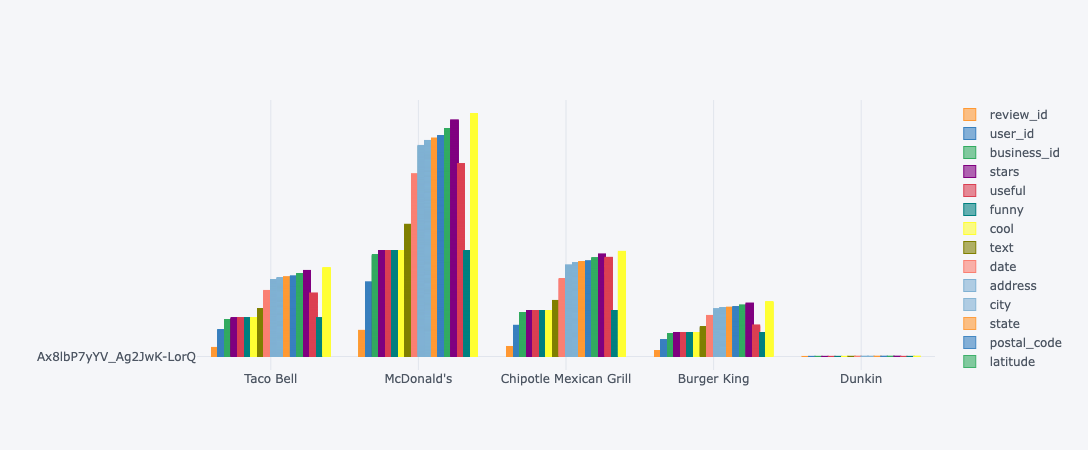

In [29]:
yelp_df.iplot(kind='bar',x='name')

<AxesSubplot:ylabel='stars'>

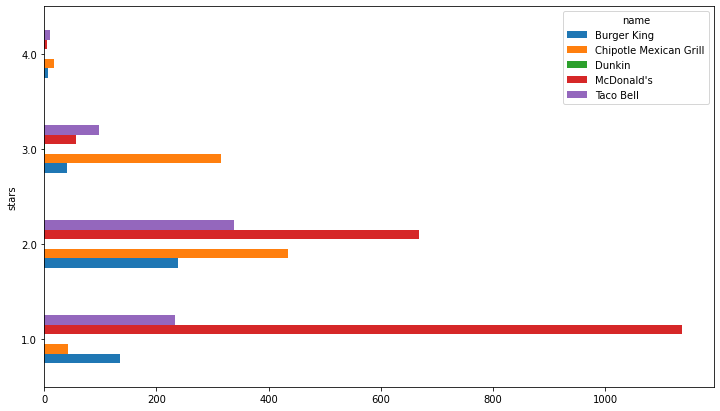

In [24]:
yelp_df.groupby('name').stars.value_counts().unstack(0).plot.barh(figsize=(12,7))

#McDonalds has the highest 1 star reviews

In [25]:
# Mcdonalds have the highest frequency than other fast food restaurants
plt.figure(figsize=(12,15))
yelp_df.groupby(['name'])['name'].count()

name
Burger King                421
Chipotle Mexican Grill     810
Dunkin                       2
McDonald's                1866
Taco Bell                  680
Name: name, dtype: int64

<Figure size 864x1080 with 0 Axes>

In [26]:
# state having the most negative reviews for Mc Donald's
reviews = yelp_df[((yelp_df['stars'] == 1)|(yelp_df['stars'] == 2))&(yelp_df['name'] == "McDonald's")]
reviews.groupby(['state'])['review_count'].count()

state
AB     17
AZ     82
CA     33
DE     17
FL    187
ID     23
IL     20
IN     97
LA    318
MO    237
NJ     53
NV     73
PA    490
TN    157
Name: review_count, dtype: int64

In [27]:
# number of McDonalds in NJ
yelp_df[(yelp_df['name']== "McDonald's") & (yelp_df['state'] == 'NJ')].groupby('name')['postal_code'].nunique()

name
McDonald's    19
Name: postal_code, dtype: int64

In [28]:
# number of McDonalds in Pennsylvania
yelp_df[(yelp_df['name']== "McDonald's") & (yelp_df['state'] == 'PA')].groupby('name')['postal_code'].nunique()

name
McDonald's    51
Name: postal_code, dtype: int64

In [29]:
# Is there any relationship between text_length and the rating?
yelp_df['text length'] = yelp_df['text'].apply(len)

<AxesSubplot:xlabel='stars', ylabel='text length'>

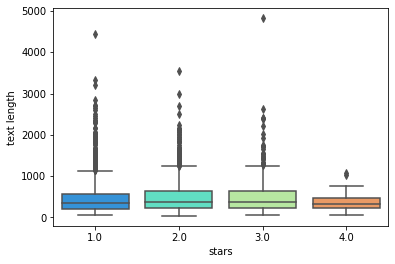

In [30]:
# Boxplot of text length for each star category

sns.boxplot(x='stars',y='text length',data=yelp_df,palette='rainbow')

<AxesSubplot:xlabel='stars', ylabel='count'>

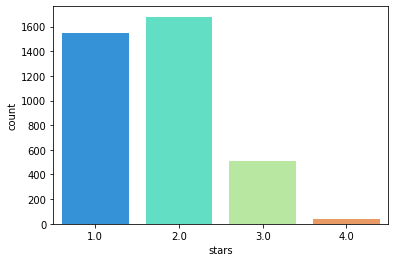

In [31]:
sns.countplot(x='stars',data=yelp_df,palette='rainbow') 
# the dataset contains more 1 or 2 star reviews than 3 or 4 star reviews
# This makes sense as people tend to put reviews when they have a bad experience


In [32]:
mc_yelp = yelp_df[yelp_df['name'] == "McDonald's"]
mc_yelp.shape

In [34]:
mc_yelp['postal_code'].nunique() # 239 McDonald's

239

In [35]:
# Let's evaluate the reviews according to four different seasons: 
#                                                                 Summer
#                                                                 Winter
#                                                             

In [36]:
mc_yelp['date'] = pd.to_datetime(mc_yelp['date'])

In [37]:
mc_yelp['month'] = mc_yelp['date'].dt.month

In [38]:
# add a season column
season_dict = {1: 'Winter',
               2: 'Winter',
               3: 'Winter', 
               4: 'Summer',
               5: 'Summer',
               6: 'Summer',
               7: 'Summer',
               8: 'Summer',
               9: 'Summer',
               10: 'Winter',
               11: 'Winter',
               12: 'Winter'}
mc_yelp['Season'] = mc_yelp['month'].apply(lambda x: season_dict[x])

In [39]:
mc_yelp['Season'].unique()

array(['Winter', 'Summer'], dtype=object)

In [40]:
# there is not much difference between summer and winter months
mc_yelp.groupby('Season')['user_id'].count()

Season
Summer    993
Winter    873
Name: user_id, dtype: int64

In [41]:
# how many are negative reviews
mc_yelp[(mc_yelp['stars'] == 1)|(mc_yelp['stars'] == 2)].groupby('Season').count()

review_id  user_id  business_id  stars  useful  funny  cool  text  \
Season                                                                      
Summer        959      959          959    959     959    959   959   959   
Winter        845      845          845    845     845    845   845   845   

        date  name  ...  city  state  postal_code  latitude  longitude  \
Season              ...                                                  
Summer   959   959  ...   959    959          959       959        959   
Winter   845   845  ...   845    845          845       845        845   

        review_count  is_open  categories  text length  month  
Season                                                         
Summer           959      959         959          959    959  
Winter           845      845         845          845    845  

[2 rows x 21 columns]

In [42]:
# Negative reviews average for each season
# Summer = 644/ 688 = 96 %
# Winter = 535/ 555 = 96 %

In [43]:
summer = mc_yelp[mc_yelp['Season'] == 'Summer']
summer.shape
summer = summer.drop(['review_id','user_id','business_id', 'useful', 'funny', 'cool', 'date','is_open', 'categories'], axis =1)

In [44]:
winter = mc_yelp[mc_yelp['Season'] == 'Winter']
winter.shape
winter = winter.drop(['review_id','user_id','business_id', 'useful', 'funny', 'cool', 'date','is_open', 'categories'], axis =1)

Text preprocessing 

Removing stopwords, Tokenization, Stemming, Lemmatization

In [46]:
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
stop_words = stopwords.words('english')

# removing everything except alphabets`
summer['text'] = summer['text'].str.replace("[^a-zA-Z#]", " ")

# removing short words
summer['text'] = summer['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
summer['text'] = summer['text'].apply(lambda x: x.lower())

# tokenization
tokenized_doc = summer['text'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

summer['text'] = tokenized_doc

from nltk.stem import WordNetLemmatizer
#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text
summer['text']=summer['text'].apply(lambda x:lemmatizer(x))

def detokenize(tokens):
    return " ".join(tokens)
summer['text'] = summer['text'].apply(detokenize)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
# removing everything except alphabets`
winter['text'] = winter['text'].str.replace("[^a-zA-Z#]", " ")

# removing short words
winter['text'] = winter['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
winter['text'] = winter['text'].apply(lambda x: x.lower())

# tokenization
tokenized_doc = winter['text'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

winter['text'] = tokenized_doc

from nltk.stem import WordNetLemmatizer
#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text
winter['text']=winter['text'].apply(lambda x:lemmatizer(x))

def detokenize(tokens):
    return " ".join(tokens)
winter['text'] = winter['text'].apply(detokenize)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [287]:
# Summer Months

Sentiment Analysis

In [ ]:
# Polarity is the output that lies between [-1,1], where -1 refers to negative sentiment and +1 refers to positive sentiment.
# Subjectivity is the output that lies within [0,1] and refers to personal opinions and judgments.
# The compound score is the sum of positive, negative & neutral scores which is then normalized between 
# -1(most extreme negative) and +1 (most extreme positive).

In [49]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return  TextBlob(text).sentiment.polarity

In [52]:
# get subjectivity and polarity scores
summer['Subjectivity'] = summer['text'].apply(getSubjectivity)
summer['Polarity'] = summer['text'].apply(getPolarity)

In [53]:
# if the compound score is greater than 0.5, then it is positive
# if the compound sore is less than -0.5, then it is negative
# if the compound sore is less than -0.5, then it is negative

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']
summer['vader_Sentiment'] = summer['text'].apply(vadersentimentanalysis)
# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
summer['Vader Analysis'] = summer['vader_Sentiment'].apply(vader_analysis)
summer.head()

stars                                               text        name  \
50556    1.0  mcdonald suck worker forgot hashbrowns make oa...  McDonald's   
50563    1.0  like everyone else leaf review idiot word pref...  McDonald's   
61284    1.0  tried going four time success drive take long ...  McDonald's   
61288    1.0  fly even though crowded took minute someone co...  McDonald's   
61289    1.0  worst mcdonald face earth period strongly wish...  McDonald's   

               address          city state postal_code   latitude  longitude  \
50556      2951 Hwy 90      Avondale    LA       70094  29.909168 -90.204384   
50563      2951 Hwy 90      Avondale    LA       70094  29.909168 -90.204384   
61284  1201 N Broad St  Philadelphia    PA       19122  39.972096 -75.158809   
61288  1201 N Broad St  Philadelphia    PA       19122  39.972096 -75.158809   
61289  1201 N Broad St  Philadelphia    PA       19122  39.972096 -75.158809   

       review_count  text length  month  Season  Subjectivity  Polarity  \
50556            10          198      6  Summer      0.383333  0.233333   
50563            10          123      8  Summer      0.645238 -0.414286   
61284            38          144      7  Summer      0.432857  0.035714   
61288            38          307      8  Summer      0.450000  0.400000   
61289            38          447      8  Summer      0.776190 -0.052381   

       vader_Sentiment Vader Analysis  
50556          -0.1779        Neutral  
50563           0.1729        Neutral  
61284           0.6705       Positive  
61288           0.4019        Neutral  
61289          -0.4077        Neutral

In [54]:
summer['Vader Analysis'].value_counts()

Neutral     397
Negative    354
Positive    242
Name: Vader Analysis, dtype: int64

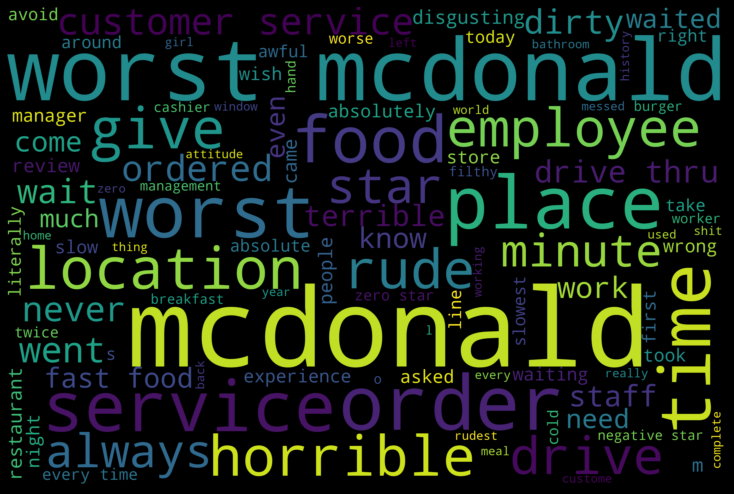

In [67]:
from wordcloud import WordCloud
word_cl_neg = summer[summer['Vader Analysis'] == 'Negative']
word_cl_neg['text'] = word_cl_neg['text'].values

wordcloud = WordCloud(max_words=100,
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(word_cl_neg['text']))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

# Negative reviews in summer months

worst mcdonald

dirty

wait (probably wait time)

customer service

rude

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
tfidf = TfidfVectorizer()
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

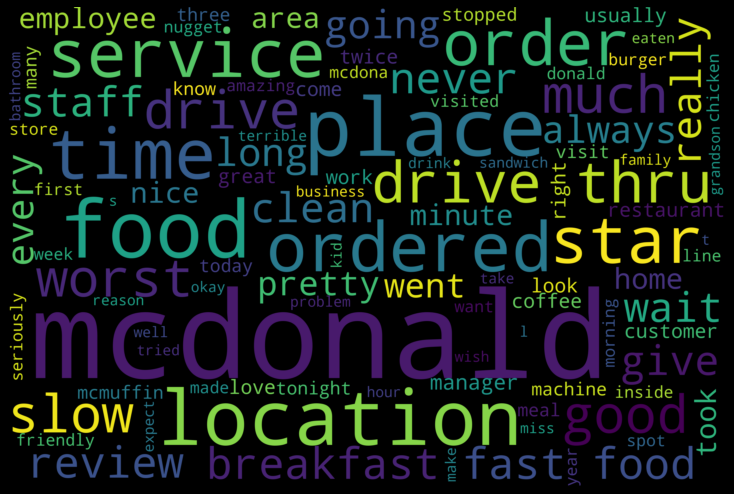

In [66]:
from wordcloud import WordCloud
word_cl_pos = summer[summer['Vader Analysis'] == 'Positive']
word_cl_pos['text'] = word_cl_pos['text'].values

wordcloud = WordCloud( max_words=100,
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(word_cl_pos['text']))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

# Positive reviews in summer months

clean

friendly

wait (probably wait time)

drive thru


However, these are just the opposites, therefore, we cannot really get any knowledge 
so we need to further dig deep into the analysis

In [165]:
summer_pos = summer[summer['Vader Analysis'] == 'Positive']
summer_neg = summer[summer['Vader Analysis'] == 'Negative']
tokenized_pos = summer_pos['text'].apply(lambda x: x.split())
tokenized_neg = summer_neg['text'].apply(lambda x: x.split())

In [166]:
pos_words = tokenized_pos.tolist()
neg_words = tokenized_neg.tolist()

# Topic Modeling using LDA

Topic modeling is a machine learning technique that automatically analyzes text data to determine cluster words for a set of documents.

In [208]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [164]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(neg_words))

print(neg_words[:1])

[['worst', 'mcdonald', 'ever', 'dirty', 'customer', 'service', 'like', 'shit', 'fly', 'place', 'food']]


In [169]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [170]:
# Remove Stop Words
data_words_nostops = remove_stopwords(neg_words)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_neg = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized_neg[:1])

[['bad', 'mcdonald', 'ever', 'dirty', 'customer', 'service', 'shit', 'fly', 'place', 'food']]


In [171]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized_neg)

# Create Corpus
texts = data_lemmatized_neg

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


<AxesSubplot:xlabel='number_of_topics', ylabel='coherence_score'>

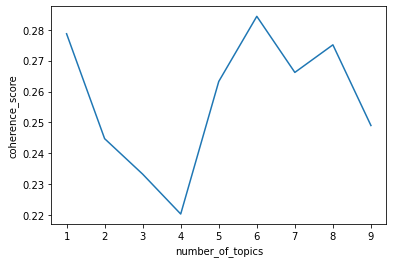

In [268]:
from gensim.models import CoherenceModel

# Compute coherence score
number_of_topics = []
coherence_score = []
for i in range(1,10):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           iterations=50,
                                           num_topics=i)
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                       texts=data_lemmatized_neg, 
                                       dictionary=id2word, 
                                       coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    number_of_topics.append(i)
    coherence_score.append(coherence_lda)

# Create a dataframe of coherence score by number of topics 
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics,
                                'coherence_score':coherence_score})

# Print a line plot
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

In [269]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [270]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.028*"mcdonald" + 0.023*"food" + 0.022*"bad" + 0.022*"place" + '
  '0.021*"order" + 0.020*"service" + 0.017*"ever" + 0.017*"even" + '
  '0.015*"customer" + 0.012*"slow"'),
 (1,
  '0.018*"mcdonald" + 0.016*"order" + 0.014*"food" + 0.013*"take" + '
  '0.013*"place" + 0.013*"away" + 0.012*"minute" + 0.012*"wait" + '
  '0.011*"employee" + 0.010*"corporate"'),
 (2,
  '0.017*"hang" + 0.017*"face" + 0.016*"joke" + 0.014*"hungry" + 0.011*"gross" '
  '+ 0.009*"burger" + 0.009*"night" + 0.008*"cool" + 0.008*"state" + '
  '0.008*"poisoning"'),
 (3,
  '0.031*"order" + 0.026*"time" + 0.019*"food" + 0.018*"customer" + '
  '0.016*"mcdonald" + 0.016*"service" + 0.014*"employee" + 0.013*"staff" + '
  '0.013*"give" + 0.013*"bad"'),
 (4,
  '0.050*"order" + 0.022*"food" + 0.018*"meal" + 0.017*"give" + '
  '0.015*"mcdonald" + 0.014*"say" + 0.013*"drink" + 0.013*"come" + 0.012*"fry" '
  '+ 0.011*"coffee"'),
 (5,
  '0.014*"expect" + 0.012*"people" + 0.009*"think" + 0.008*"enough" + '
  '0.007*"door"

In [271]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized_neg, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.936336026714935

Coherence Score:  0.31647767472794813


In [272]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.158760 -0.042030       1        1  33.811702
4     -0.080538 -0.118004       2        1  19.253396
0     -0.084499  0.189429       3        1  18.688537
1     -0.075971 -0.023024       4        1  17.975405
5      0.213302 -0.027248       5        1   7.181234
2      0.186465  0.020877       6        1   3.089725, topic_info=                 Term        Freq       Total Category  logprob  loglift
122             order  316.000000  316.000000  Default  30.0000  30.0000
1            customer  107.000000  107.000000  Default  29.0000  29.0000
255              meal   45.000000   45.000000  Default  28.0000  28.0000
7               place  112.000000  112.000000  Default  27.0000  27.0000
17               give   94.000000   94.000000  Default  26.0000  26.0000
299              away   27.000000   27.000000  Default  25.0000  25.0000
8             service  121.000000  121.000000  Default  24.0000  24.0000
406            people   68.000000   68.000000  Default  23.0000  23.0000
44               time  145.000000  145.000000  Default  22.0000  22.0000
38               hard   25.000000   25.000000  Default  21.0000  21.0000
157              slow   35.000000   35.000000  Default  20.0000  20.0000
186             drink   48.000000   48.000000  Default  19.0000  19.0000
239             think   25.000000   25.000000  Default  18.0000  18.0000
148               fry   49.000000   49.000000  Default  17.0000  17.0000
99          corporate   24.000000   24.000000  Default  16.0000  16.0000
278            coffee   37.000000   37.000000  Default  15.0000  15.0000
429              look   41.000000   41.000000  Default  14.0000  14.0000
120             night   23.000000   23.000000  Default  13.0000  13.0000
16              first   34.000000   34.000000  Default  12.0000  12.0000
741             floor   20.000000   20.000000  Default  11.0000  11.0000
284               see   20.000000   20.000000  Default  10.0000  10.0000
577            expect   12.000000   12.000000  Default   9.0000   9.0000
2               dirty   27.000000   27.000000  Default   8.0000   8.0000
225              hour   33.000000   33.000000  Default   7.0000   7.0000
259             shake   20.000000   20.000000  Default   6.0000   6.0000
228              joke    9.000000    9.000000  Default   5.0000   5.0000
356              much   29.000000   29.000000  Default   4.0000   4.0000
3                ever  106.000000  106.000000  Default   3.0000   3.0000
0                 bad  143.000000  143.000000  Default   2.0000   2.0000
21            manager   49.000000   49.000000  Default   1.0000   1.0000
16              first   34.304970   34.950475   Topic1  -4.7502   1.0657
225              hour   33.270035   33.913783   Topic1  -4.7808   1.0652
211              care   17.722041   18.366798   Topic1  -5.4106   1.0486
18               hear   15.340304   15.983989   Topic1  -5.5550   1.0433
1296            issue   14.433590   15.077351   Topic1  -5.6159   1.0407
670            cancel   14.132143   14.769946   Topic1  -5.6370   1.0402
15      establishment   13.901489   14.545381   Topic1  -5.6535   1.0391
317             phone   12.881662   13.520203   Topic1  -5.7297   1.0360
306        disgusting   19.709191   20.759778   Topic1  -5.3044   1.0324
806           deserve   12.046716   12.691202   Topic1  -5.7967   1.0322
874              hope   10.950328   11.593610   Topic1  -5.8921   1.0273
1035          garbage   11.233118   11.907968   Topic1  -5.8666   1.0260
334             close   30.994359   32.863886   Topic1  -4.8517   1.0258
1198          clearly   13.250677   14.067647   Topic1  -5.7014   1.0245
669              busy   10.466575   11.113315   Topic1  -5.9373   1.0244
637           sausage   10.141386   10.786910   Topic1  -5.9688   1.0227
593             later    9.876982   10.515677   Topic1  -5.9952   1.0217
417         franchise

In [223]:
pip install tfidf

Note: you may need to restart the kernel to use updated packages.


In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

In [318]:
from sklearn.decomposition import LatentDirichletAllocation
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(3,4))
lda = LatentDirichletAllocation(n_components=20)
pipe = make_pipeline(tfidf_vectorizer, lda)
pipe.fit(summer_neg['text'])
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
print_top_words(lda, tfidf_vectorizer.get_feature_names(), n_top_words=3)

Topic #0: worst mcdonald ever, ever long line, experience ever long
Topic #1: worst mcdonald ever reason, shutdown restaff completely, reason believe shutdown restaff
Topic #2: order wrong terrible, wrong terrible customer, customer service clean impressed
Topic #3: ever tasted looked, ever tasted looked like, tasted looked like hockey
Topic #4: poor customer service, customer service worst mcdonald, everything dirty poor
Topic #5: employee rude hateful take, drive mile back, sigh roll drive
Topic #6: nastiest mcdonald ever, mcdonald ever employee unfriendly, mcdonald ever employee
Topic #7: favor mcdonald street, service favor mcdonald street, terrible service favor mcdonald
Topic #8: shake machine broken, least show much hate, least show much
Topic #9: people work care anything, complete order people, mcdonald around never
Topic #10: issue picture talking forget, issue picture talking, disappointed mcdonalds could list
Topic #11: never mcdonalds wait, mcdonalds wait better, absolutel

In [323]:
from sklearn.decomposition import LatentDirichletAllocation
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(3,4))
lda = LatentDirichletAllocation(n_components=20)
pipe = make_pipeline(tfidf_vectorizer, lda)
pipe.fit(summer_pos['text'])
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
print_top_words(lda, tfidf_vectorizer.get_feature_names(), n_top_words=3)


Topic #0: around business deal, business deal food, deal food fine
Topic #1: happy meal happy, mcdonald location hamilton county, good service decent
Topic #2: waiting food breakfast, chair waiting food, donut street wait
Topic #3: good food even, place suck literally tried, tried never gotten
Topic #4: monte drive thru, line monte drive, mcnuggets like burned health
Topic #5: service manager many, many server friendly nite, service manager many server
Topic #6: delivery service driver, mcdouble friend evening heading, slowest drive history
Topic #7: going took forever, service cause manager, place going took
Topic #8: teach done great, together people maybe folk, westport store teach done
Topic #9: half step eating fry, cold mcdonald yesterday spot, love cold mcdonald
Topic #10: always drink mcdonalds coffee, come back vega, much ready come back
Topic #11: chin guard mouth nose, nose pretty fascinating, staff appear think
Topic #12: update simply nice people, nice people good food, pe

In [ ]:
# Non summer months

In [288]:
winter['Subjectivity'] = winter['text'].apply(getSubjectivity)
winter['Polarity'] = winter['text'].apply(getPolarity)

In [289]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']
winter['vader_Sentiment'] = winter['text'].apply(vadersentimentanalysis)
# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
winter['Vader Analysis'] = winter['vader_Sentiment'].apply(vader_analysis)
winter.head()

stars  \
50554    1.0   
50555    1.0   
50557    1.0   
50558    1.0   
50559    1.0   

                                                                                                      text  \
50554  rude inattentive uneducated always make feel bothering started using mobile order le idiot deal ...   
50555  stopped bathroom break drink large rude service husband stood min lady back talking said place o...   
50557                                                   place nasty employee lazy napkin lobby lobby dirty   
50558  could give zero star would never order right right pull always acting like believe receipt fry c...   
50559             chaos thing seem happen accidentally still mcdonald sameness imposed structure franchise   

             name      address      city state postal_code   latitude  \
50554  McDonald's  2951 Hwy 90  Avondale    LA       70094  29.909168   
50555  McDonald's  2951 Hwy 90  Avondale    LA       70094  29.909168   
50557  McDonald's  2951 Hwy 90  Avondale    LA       70094  29.909168   
50558  McDonald's  2951 Hwy 90  Avondale    LA       70094  29.909168   
50559  McDonald's  2951 Hwy 90  Avondale    LA       70094  29.909168   

       longitude  review_count  text length  month  Season  Subjectivity  \
50554 -90.204384            10          278      3  Winter      0.700000   
50555 -90.204384            10          388      1  Winter      0.525714   
50557 -90.204384            10          108     11  Winter      0.933333   
50558 -90.204384            10          326      2  Winter      0.482143   
50559 -90.204384            10          147     12  Winter      0.000000   

       Polarity  vader_Sentiment Vader Analysis  
50554 -0.550000          -0.8360       Negative  
50555  0.042857          -0.8885       Negative  
50557 -0.616667          -0.8316       Negative  
50558 -0.035714          -0.5574       Negative  
50559  0.000000          -0.7506       Negative

In [290]:
winter['Vader Analysis'].value_counts()

Neutral     358
Negative    312
Positive    203
Name: Vader Analysis, dtype: int64

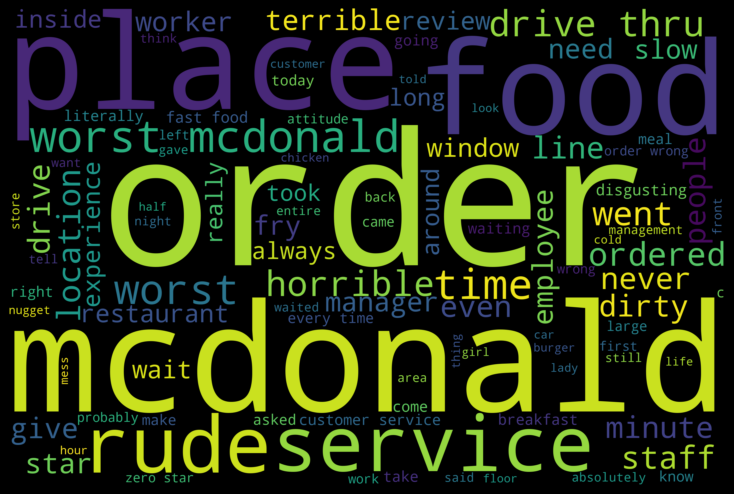

In [292]:
from wordcloud import WordCloud
word_cl_neg = winter[winter['Vader Analysis'] == 'Negative']
word_cl_neg['text'] = word_cl_neg['text'].values

wordcloud = WordCloud(max_words=100,
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(word_cl_neg['text']))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

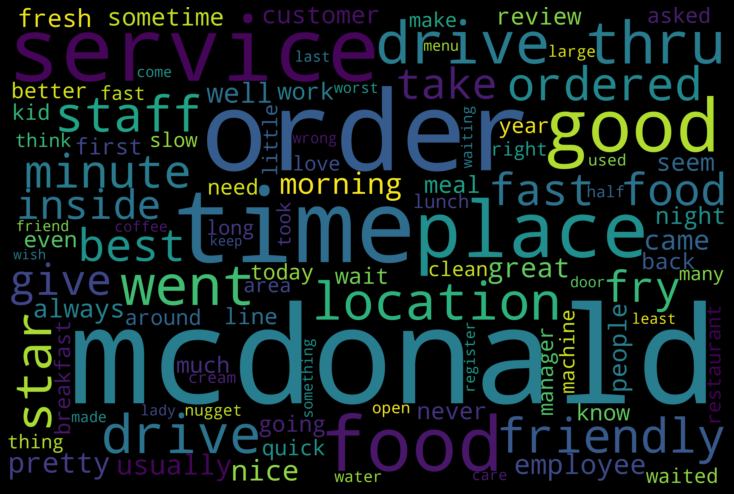

In [293]:
from wordcloud import WordCloud
word_cl_pos = winter[winter['Vader Analysis'] == 'Positive']
word_cl_pos['text'] = word_cl_pos['text'].values

wordcloud = WordCloud( max_words=100,
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(word_cl_pos['text']))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

In [294]:
winter_pos = winter[winter['Vader Analysis'] == 'Positive']
winter_neg = winter[winter['Vader Analysis'] == 'Negative']
tokenized_pos = winter_pos['text'].apply(lambda x: x.split())
tokenized_neg = winter_neg['text'].apply(lambda x: x.split())

In [295]:
pos_words = tokenized_pos.tolist()
neg_words = tokenized_neg.tolist()

In [296]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(neg_words))

print(neg_words[:1])

[['rude', 'inattentive', 'uneducated', 'always', 'make', 'feel', 'bothering', 'started', 'using', 'mobile', 'order', 'le', 'idiot', 'deal', 'within', 'chain', 'start', 'making', 'hour', 'ordering', 'kiosk', 'maybe', 'dealing', 'person']]


In [297]:
# Remove Stop Words
data_words_nostops = remove_stopwords(neg_words)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_neg = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized_neg[:1])

[['uneducated', 'always', 'make', 'feel', 'bother', 'start', 'use', 'mobile', 'order', 'chain', 'start', 'make', 'hour', 'order', 'kiosk', 'maybe', 'deal', 'person']]


In [298]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized_neg)

# Create Corpus
texts = data_lemmatized_neg

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 2), (11, 1), (12, 2), (13, 1), (14, 1)]]


<AxesSubplot:xlabel='number_of_topics', ylabel='coherence_score'>

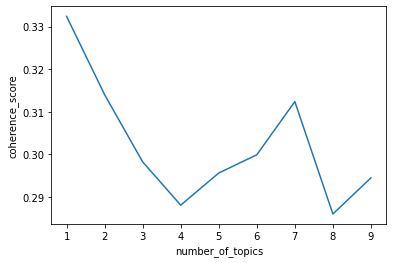

In [299]:
from gensim.models import CoherenceModel

# Compute coherence score
number_of_topics = []
coherence_score = []
for i in range(1,10):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           iterations=50,
                                           num_topics=i)
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                       texts=data_lemmatized_neg, 
                                       dictionary=id2word, 
                                       coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    number_of_topics.append(i)
    coherence_score.append(coherence_lda)

# Create a dataframe of coherence score by number of topics 
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics,
                                'coherence_score':coherence_score})

# Print a line plot
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

In [300]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [301]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.038*"order" + 0.026*"mcdonald" + 0.024*"give" + 0.022*"time" + '
  '0.021*"food" + 0.020*"drive" + 0.016*"bad" + 0.015*"never" + 0.013*"ever" + '
  '0.013*"back"'),
 (1,
  '0.046*"slow" + 0.034*"breakfast" + 0.024*"offer" + 0.023*"often" + '
  '0.019*"lunch" + 0.017*"drive" + 0.017*"order" + 0.017*"price" + '
  '0.017*"hamburger" + 0.017*"mcdonald"'),
 (2,
  '0.034*"fry" + 0.021*"call" + 0.015*"cheese" + 0.015*"probably" + '
  '0.014*"mention" + 0.013*"french" + 0.013*"number" + 0.012*"disrespectful" + '
  '0.012*"story" + 0.011*"steak"'),
 (3,
  '0.034*"wait" + 0.031*"minute" + 0.029*"drive" + 0.023*"go" + 0.019*"line" + '
  '0.018*"time" + 0.017*"order" + 0.016*"ask" + 0.015*"finally" + '
  '0.014*"experience"'),
 (4,
  '0.025*"place" + 0.021*"order" + 0.017*"menu" + 0.015*"food" + '
  '0.014*"worker" + 0.014*"regular" + 0.013*"mcdonald" + 0.012*"people" + '
  '0.012*"always" + 0.012*"floor"'),
 (5,
  '0.033*"gross" + 0.030*"shake" + 0.025*"weather" + 0.015*"call" + '
  '0.

In [302]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized_neg, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.951095683907026

Coherence Score:  0.32771186253554396


In [303]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.188856  0.077440       1        1  47.647910
3      0.168343 -0.054624       2        1  19.266143
4     -0.013773  0.173699       3        1  16.724656
2     -0.178830 -0.043502       4        1   6.912202
1      0.018378 -0.192766       5        1   5.200977
5     -0.182974  0.039753       6        1   4.248112, topic_info=                 Term        Freq       Total Category  logprob  loglift
138              wait   96.000000   96.000000  Default  30.0000  30.0000
75              drive  176.000000  176.000000  Default  29.0000  29.0000
26              place  119.000000  119.000000  Default  28.0000  28.0000
137            minute   82.000000   82.000000  Default  27.0000  27.0000
44                fry   52.000000   52.000000  Default  26.0000  26.0000
370         breakfast   44.000000   44.000000  Default  25.0000  25.0000
659              slow   31.000000   31.000000  Default  24.0000  24.0000
29            service   79.000000   79.000000  Default  23.0000  23.0000
220                go  109.000000  109.000000  Default  22.0000  22.0000
423              call   33.000000   33.000000  Default  21.0000  21.0000
58           mcdonald  196.000000  196.000000  Default  20.0000  20.0000
239              line   69.000000   69.000000  Default  19.0000  19.0000
198              menu   31.000000   31.000000  Default  18.0000  18.0000
93                bad  123.000000  123.000000  Default  17.0000  17.0000
464             gross   16.000000   16.000000  Default  16.0000  16.0000
67              shake   19.000000   19.000000  Default  15.0000  15.0000
140               ask   78.000000   78.000000  Default  14.0000  14.0000
252           finally   32.000000   32.000000  Default  13.0000  13.0000
74           customer   78.000000   78.000000  Default  12.0000  12.0000
197          location   73.000000   73.000000  Default  11.0000  11.0000
218        experience   31.000000   31.000000  Default  10.0000  10.0000
877           regular   26.000000   26.000000  Default   9.0000   9.0000
377              else   20.000000   20.000000  Default   8.0000   8.0000
1036            offer   14.000000   14.000000  Default   7.0000   7.0000
77               even   88.000000   88.000000  Default   6.0000   6.0000
247              cold   34.000000   34.000000  Default   5.0000   5.0000
784             often   13.000000   13.000000  Default   4.0000   4.0000
399           receive   26.000000   26.000000  Default   3.0000   3.0000
1530          weather   12.000000   12.000000  Default   2.0000   2.0000
326            worker   38.000000   38.000000  Default   1.0000   1.0000
161             staff   51.430641   51.991404   Topic1  -4.6225   0.7305
83               need   49.397568   49.966129   Topic1  -4.6629   0.7299
153              look   46.798357   47.354665   Topic1  -4.7169   0.7295
809             awful   38.568610   39.122646   Topic1  -4.9103   0.7271
65           horrible   34.811621   35.426808   Topic1  -5.0128   0.7238
125              well   41.875514   42.659090   Topic1  -4.8281   0.7228
574          business   27.117450   27.676695   Topic1  -5.2626   0.7209
52               star   40.559067   41.411366   Topic1  -4.8600   0.7205
188             store   23.357415   23.913687   Topic1  -5.4119   0.7178
414               try   24.797224   25.389154   Topic1  -5.3520   0.7177
635           ketchup   24.438183   25.025056   Topic1  -5.3666   0.7176
90           terrible   23.335912   23.917060   Topic1  -5.4128   0.7167
209            reason   31.456567   32.245297   Topic1  -5.1142   0.7166
290      cheeseburger   23.437362   24.025061   Topic1  -5.4084   0.7166
116             night   20.740467   21.300623   Topic1  -5.5307   0.7147
146     establishment   18.146017   18.704429   Topic1  -5.6643   0.7110
24               nice   17.126889   17.683102   Topic1  -5.7221   0.7094
105              girl

In [324]:
from sklearn.decomposition import LatentDirichletAllocation
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(3,4))
lda = LatentDirichletAllocation(n_components=20)
pipe = make_pipeline(tfidf_vectorizer, lda)
pipe.fit(winter_neg['text'])
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
print_top_words(lda, tfidf_vectorizer.get_feature_names(), n_top_words=3)

Topic #0: worst donalds entire, donalds entire life critical, donalds entire life
Topic #1: horrible renovated staff, food horrible service horrible, horrible service horrible
Topic #2: cashier disgusting attitude food, disgusting attitude food thrown, food thrown together even
Topic #3: get order right worst, mcdonald avoid always, right worst mcdonald avoid
Topic #4: eating inside mistake, inside mistake felt really, uncomfortable never inside
Topic #5: worst mcdonalds ever, spilled stain smell, covered spilled stain
Topic #6: easier broken order take, worse mcdonald complaining matter, matter dirty worker
Topic #7: time since machine frustrating, since machine frustrating, machine frustrating going month
Topic #8: completely incompetent going minute, waiting nugget fry, going minute waiting nugget
Topic #9: ever branch need, branch need closed, horrific customer service worst
Topic #10: ordered kid meal yogurt, coffee horrible bitter, yogurt iced coffee horrible
Topic #11: service h

In [320]:
from sklearn.decomposition import LatentDirichletAllocation
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(3,4))
lda = LatentDirichletAllocation(n_components=10)
pipe = make_pipeline(tfidf_vectorizer, lda)
pipe.fit(winter_pos['text'])
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
print_top_words(lda, tfidf_vectorizer.get_feature_names(), n_top_words=3)

Topic #0: bagel sandwich cold, nice bagel sandwich cold, hash brown pretty
Topic #1: much kinda started, mcdonald much kinda, kinda started liking
Topic #2: even first line, window worth even fry, line drive thru window
Topic #3: good mcdonalds service fair, said ketchup nugget good, fair food better daytime
Topic #4: mcdonalds occasional mickyd, occasional mickyd usually breakfast, mickyd usually breakfast different
Topic #5: used best location, dive save time drive, taken nose dive save
Topic #6: wanna twice fry pretty, wouldnt wanna twice, wouldnt wanna twice fry
Topic #7: much good mcdonald clearly, mcdonald clearly lovin, good mcdonald clearly
Topic #8: order oatmeal morning minute, well wish could, filling order oatmeal morning
Topic #9: welcome lady taking, courtesy thank welcome, courtesy thank welcome lady



# Recommendations for improving McDonald's customer satisfaction in Non Summer months
 
 long lines
 
 waiting time 
 
 slow service
 
 worst customer service: unfriendly, unhelpful, rude, hateful
 
 messed up orders: regular coke instead diet
 
 vegan is not good: harsh anything vegan like
 
 dirty: shit fly place food, mcdonald ever dirty, bathroom disgusting
 
 

# Recommendations for improving McDonald's customer satisfaction in Non Summer months
horrible extra disorganized
 
place nasty

smells bad

employee lazy
 
dirty cashier disgusting attitude

cold hash brown, coffee horrible bitter, yogurt iced coffee horrible